## Finding Pits with Graupel

**Goal**: Find all pits with graupel mentioned in the comments by the observers.

**Approach**: 

1. Use the `LayerData` class to represent the entire layers table
2. Form the query using Objet Relational Mapping (ORM)
3. Use the conversion function from snowxsql to get a geodataframe
5. Plot it!

In [11]:
from snowxsql.data import LayerData
from snowxsql.db import get_db
from snowxsql.conversions import query_to_geopandas
import geopandas as gpd
from sqlalchemy.dialects import postgresql
import matplotlib.pyplot as plt 

# Connect to the database we made.
db_name = 'postgresql+psycopg2:///snowex'
engine, metadata, session = get_db(db_name)

# Query the database looking at LayerData, filter on comments containing graupel (case insensitive)
q = session.query(LayerData).filter(LayerData.comments.contains('graupel'))

# Convert the 
df = query_to_geopandas(q, engine)

# Close the geoalchemy2 session
session.close()

# Write data to a shapefile
# df['geom'].to_file('graupel_locations.shp')


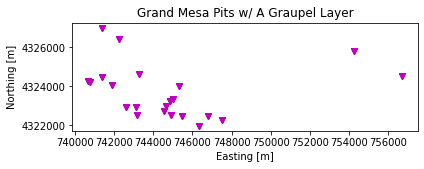

In [15]:
ax = df.plot(color='m', marker='v')
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
ax.ticklabel_format(style='plain', useOffset=False)
ax.set_title('Grand Mesa Pits w/ A Graupel Layer')
plt.tight_layout()